# Import the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load data
df = pd.read_csv('2025-VeloCityX-Expanded-Fan-Engagement-Data.csv')

df.head()

,User ID,Fan Challenges Completed,Predictive Accuracy (%),Virtual Merchandise Purchases,Sponsorship Interactions (Ad Clicks),Time on Live 360 (mins),Real-Time Chat Activity (Messages Sent)
0,U001,5,80,3,10,120,20
1,U002,8,60,1,8,100,35
2,U003,3,90,0,6,90,5
3,U004,7,70,2,15,140,40
4,U005,2,50,5,3,60,8


In [2]:
# Check for missing values
df.isnull().sum()

User ID                                    0
Fan Challenges Completed                   0
Predictive Accuracy (%)                    0
Virtual Merchandise Purchases              0
Sponsorship Interactions (Ad Clicks)       0
Time on Live 360 (mins)                    0
Real-Time Chat Activity (Messages Sent)    0
dtype: int64

In [3]:
df.describe()

,Fan Challenges Completed,Predictive Accuracy (%),Virtual Merchandise Purchases,Sponsorship Interactions (Ad Clicks),Time on Live 360 (mins),Real-Time Chat Activity (Messages Sent)
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.790000,74.990000,2.670000,8.680000,129.350000,25.050000
std,2.825908,14.033506,2.064882,6.340315,38.634358,14.163101
min,1.000000,50.000000,0.000000,0.000000,60.000000,0.000000
25%,3.000000,62.000000,1.000000,2.000000,98.000000,11.000000
50%,6.000000,77.000000,2.000000,8.000000,124.500000,25.500000
75%,8.000000,86.500000,5.000000,15.000000,160.000000,35.000000
max,10.000000,98.000000,6.000000,19.000000,199.000000,49.000000


# Feature engineering

In [4]:
# Create Engagement Level feature
df['Engagement Level'] = df['Time on Live 360 (mins)'] + df['Real-Time Chat Activity (Messages Sent)']

# Create Challenge Success Ratio feature
df['Challenge Success Ratio'] = df['Predictive Accuracy (%)'] / df['Fan Challenges Completed']

# Preview the new features
df[['User ID', 'Engagement Level', 'Challenge Success Ratio']].head()

,User ID,Engagement Level,Challenge Success Ratio
0,U001,140,16.0
1,U002,135,7.5
2,U003,95,30.0
3,U004,180,10.0
4,U005,68,25.0


In [5]:
# Create a binary feature indicating whether a user purchased virtual merchandise
df['Merchandise Purchaser'] = df['Virtual Merchandise Purchases'].apply(lambda x: 1 if x > 0 else 0)

# Create a categorical feature for active engagement
df['Active Engagement'] = df['Time on Live 360 (mins)'].apply(lambda x: 0 if x > 100 else 1)

# Preview the new columns
df[['User ID', 'Merchandise Purchaser', 'Active Engagement']].head()

,User ID,Merchandise Purchaser,Active Engagement
0,U001,1,0
1,U002,1,1
2,U003,0,1
3,U004,1,0
4,U005,1,1


In [6]:
# Bin 'Time on Live 360' into 2 categories
df['Live 360 Category'] = pd.cut(df['Time on Live 360 (mins)'], bins=[0, 79, float('inf')], labels=[0, 1])
df[['User ID', 'Time on Live 360 (mins)', 'Live 360 Category']].head()

,User ID,Time on Live 360 (mins),Live 360 Category
0,U001,120,1
1,U002,100,1
2,U003,90,1
3,U004,140,1
4,U005,60,0


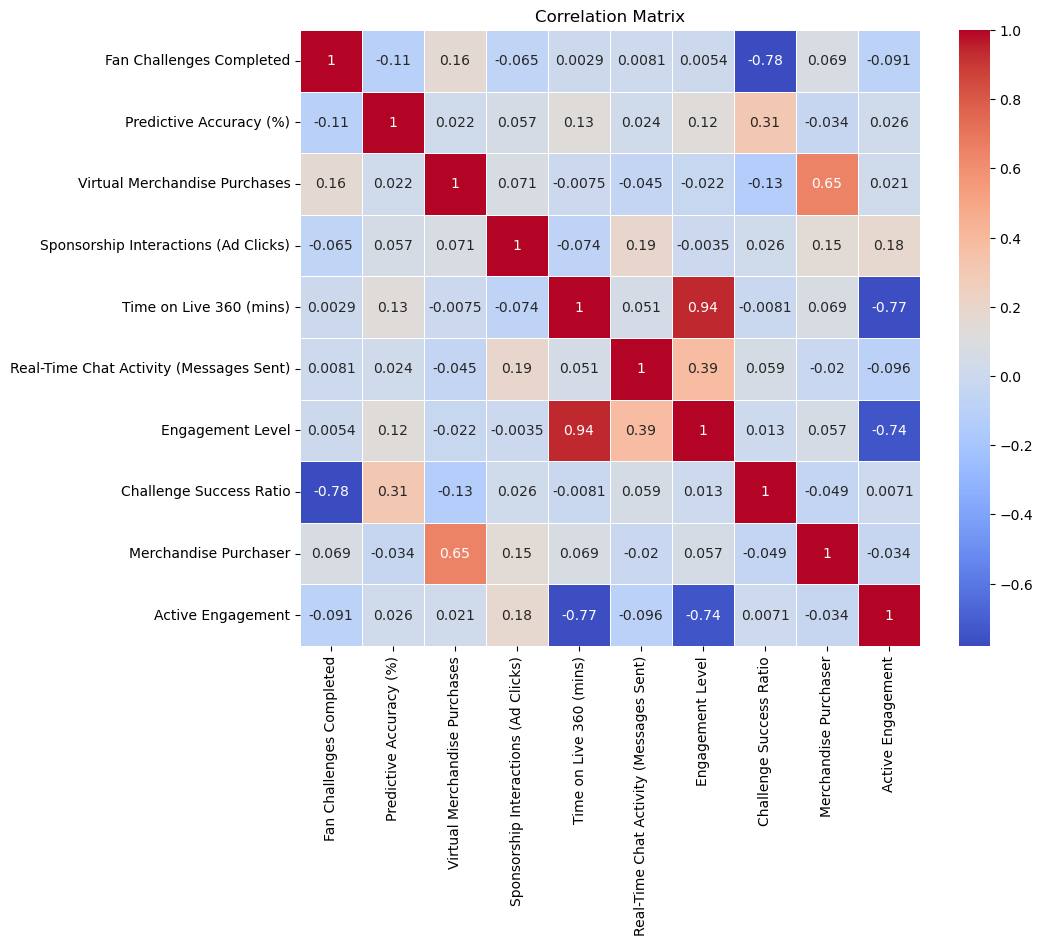

In [7]:
# Compute correlation matrix
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Correlation analysis for virtual merchandise purchases
corr_matrix = df[['Fan Challenges Completed', 'Predictive Accuracy (%)', 'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)', 'Virtual Merchandise Purchases', 'Merchandise Purchaser', 'Active Engagement']].corr()

# Display the correlation of virtual merchandise purchases with other features
corr_matrix['Virtual Merchandise Purchases'].sort_values(ascending=False)

Virtual Merchandise Purchases              1.000000
Merchandise Purchaser                      0.649783
Fan Challenges Completed                   0.159378
Sponsorship Interactions (Ad Clicks)       0.070550
Predictive Accuracy (%)                    0.022194
Active Engagement                          0.020940
Time on Live 360 (mins)                   -0.007527
Real-Time Chat Activity (Messages Sent)   -0.044676
Name: Virtual Merchandise Purchases, dtype: float64

# The Best feature to predict if a user will purchase is whether he already purchases in the past or not, and then the number of challenges completed

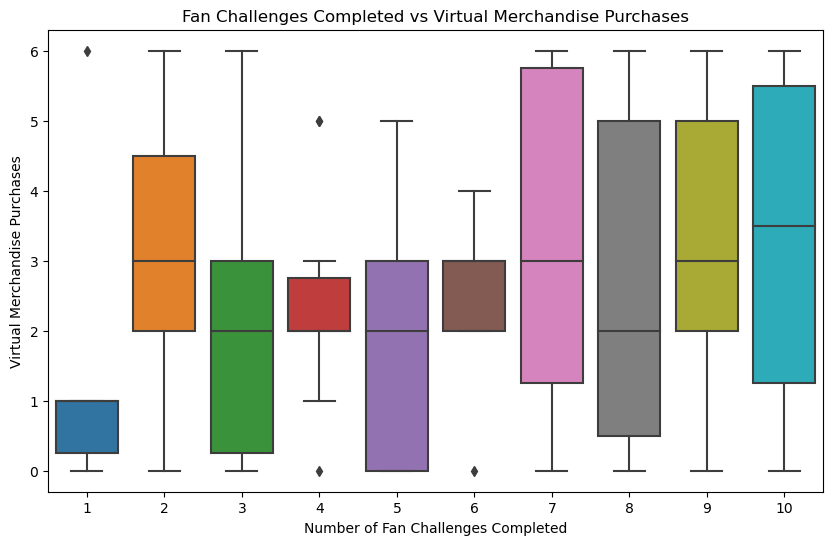

In [9]:
# Group the users by the number of fan challenges completed and view the average merchandise purchases
fan_challenges_vs_merchandise = df.groupby('Fan Challenges Completed')['Virtual Merchandise Purchases'].mean()

plt.figure(figsize=(10,6))
sns.boxplot(x='Fan Challenges Completed', y='Virtual Merchandise Purchases', data=df)
plt.title('Fan Challenges Completed vs Virtual Merchandise Purchases')
plt.xlabel('Number of Fan Challenges Completed')
plt.ylabel('Virtual Merchandise Purchases')
plt.show()

In [10]:
corr_matrix['Sponsorship Interactions (Ad Clicks)'].sort_values(ascending=False)

Sponsorship Interactions (Ad Clicks)       1.000000
Real-Time Chat Activity (Messages Sent)    0.191292
Active Engagement                          0.177239
Merchandise Purchaser                      0.145042
Virtual Merchandise Purchases              0.070550
Predictive Accuracy (%)                    0.056612
Fan Challenges Completed                  -0.065239
Time on Live 360 (mins)                   -0.073929
Name: Sponsorship Interactions (Ad Clicks), dtype: float64

# The Best feature to predict the Sponsorship interaction is the Real Time Chat Activity

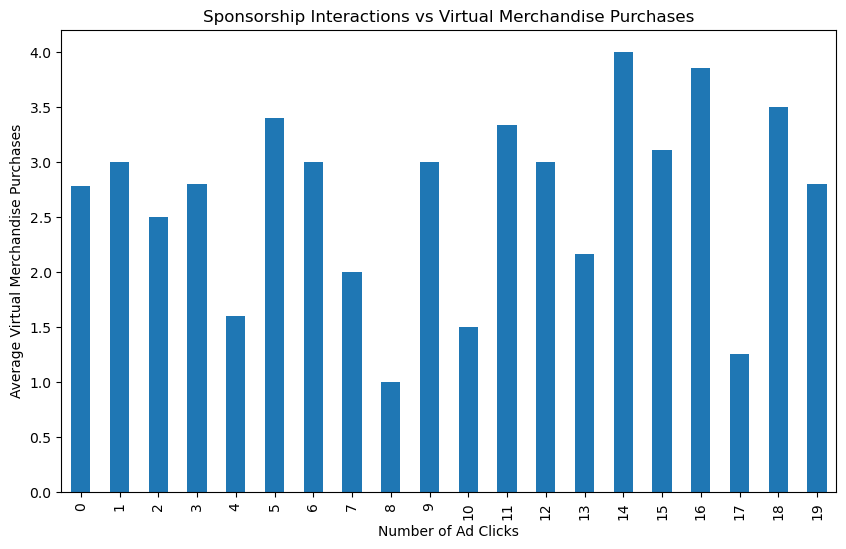

In [11]:
# Group the users by sponsorship interactions and view the average merchandise purchases
sponsorship_vs_merchandise = df.groupby('Sponsorship Interactions (Ad Clicks)')['Virtual Merchandise Purchases'].mean()

plt.figure(figsize=(10,6))
sponsorship_vs_merchandise.plot(kind='bar')
plt.title('Sponsorship Interactions vs Virtual Merchandise Purchases')
plt.xlabel('Number of Ad Clicks')
plt.ylabel('Average Virtual Merchandise Purchases')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        25

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



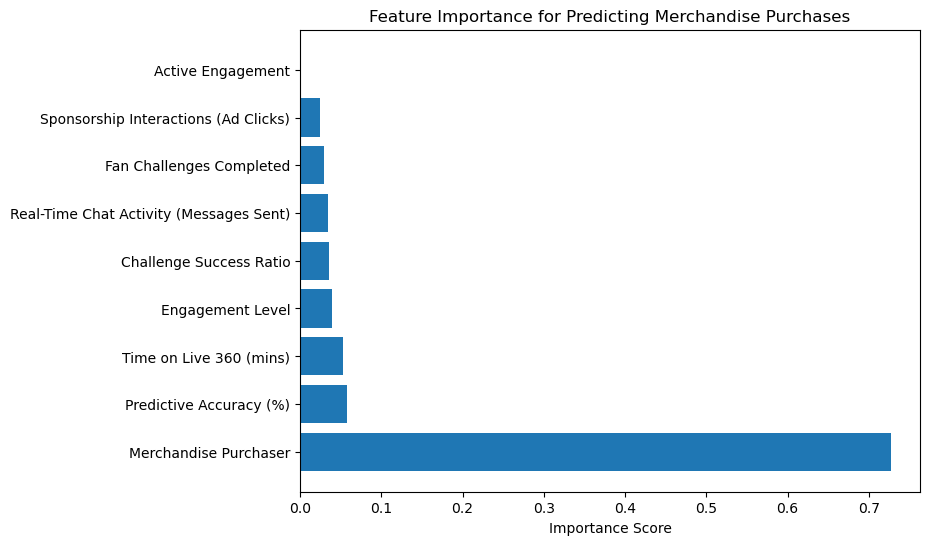

In [12]:
# Create a binary column (1 if merchandise was purchased, 0 otherwise)
df['Purchased_Merchandise'] = np.where(df['Virtual Merchandise Purchases'] > 0, 1, 0)

X = df[['Fan Challenges Completed', 'Predictive Accuracy (%)', 'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)', 'Challenge Success Ratio', 'Engagement Level', 'Merchandise Purchaser', 'Active Engagement']]
y = df['Purchased_Merchandise']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance for predicting merchandise purchases
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(8,6))
plt.title("Feature Importance for Predicting Merchandise Purchases")
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel("Importance Score")
plt.show()

# The users are most likely to purchase virtual merchandise are the ones who have already purchased !

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [14]:
# Logistic Regression
logreg_model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(f"Precision: {precision_score(y_test, y_pred_logreg)}")
print(f"Recall: {recall_score(y_test, y_pred_logreg)}")
print(f"F1 Score: {f1_score(y_test, y_pred_logreg)}")

Logistic Regression:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [15]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("K-Nearest Neighbors:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f"Precision: {precision_score(y_test, y_pred_knn)}")
print(f"Recall: {recall_score(y_test, y_pred_knn)}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn)}")

K-Nearest Neighbors:
Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091


In [16]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(f"Precision: {precision_score(y_test, y_pred_gb)}")
print(f"Recall: {recall_score(y_test, y_pred_gb)}")
print(f"F1 Score: {f1_score(y_test, y_pred_gb)}")

Gradient Boosting Classifier:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [17]:
from sklearn.cluster import KMeans

# Standardise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(pd.DataFrame(X_scaled, columns=features).head())

   Fan Challenges Completed  Predictive Accuracy (%)  \
0                 -0.280964                 0.358801   
1                  0.785989                -1.073539   
2                 -0.992267                 1.074971   
3                  0.430338                -0.357369   
4                 -1.347918                -1.789709   

   Sponsorship Interactions (Ad Clicks)  Time on Live 360 (mins)  \
0                              0.209240                -0.243232   
1                             -0.107790                -0.763514   
2                             -0.424821                -1.023655   
3                              1.001818                 0.277050   
4                             -0.900368                -1.804077   

   Real-Time Chat Activity (Messages Sent)  Challenge Success Ratio  \
0                                -0.358357                -0.214404   
1                                 0.706069                -0.672360   
2                                -1.42278

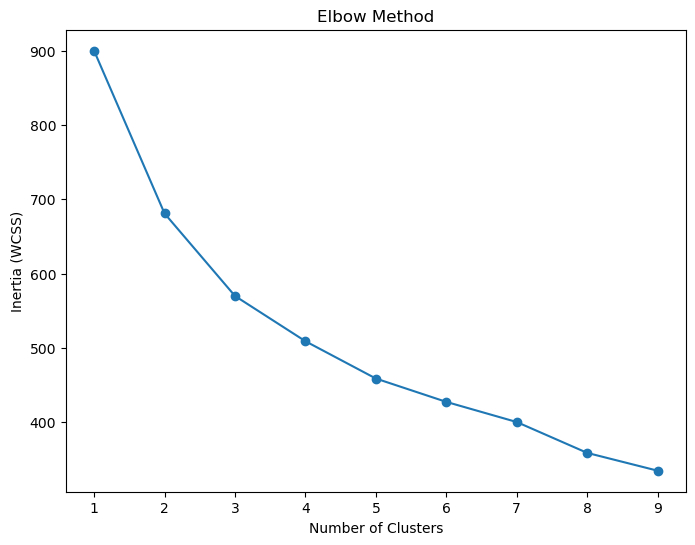

In [18]:
# Use the elbow method to determine the optimal number of clusters
wcss = []  # Inertia (Within-Cluster-Sum of Squared Distances)
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.show()

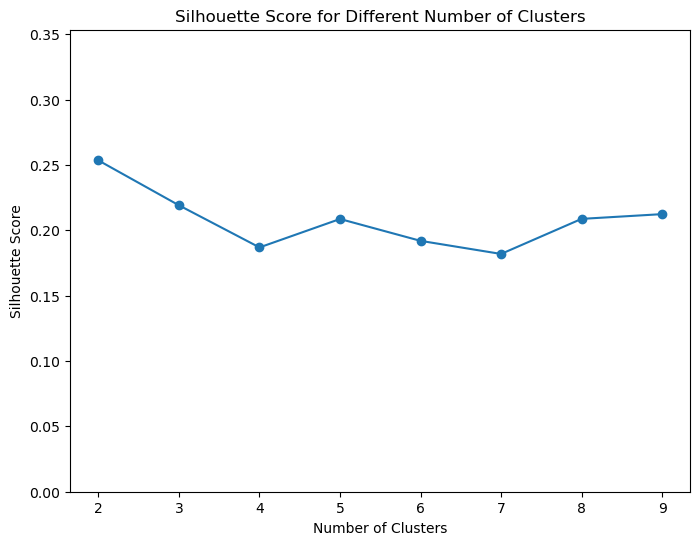

In [19]:
# Use the silhouette score to determine the optimal number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(8,6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
# make the plot start at 0 for Y variable
plt.ylim(0, max(silhouette_scores) + 0.1)
plt.title("Silhouette Score for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [20]:
# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

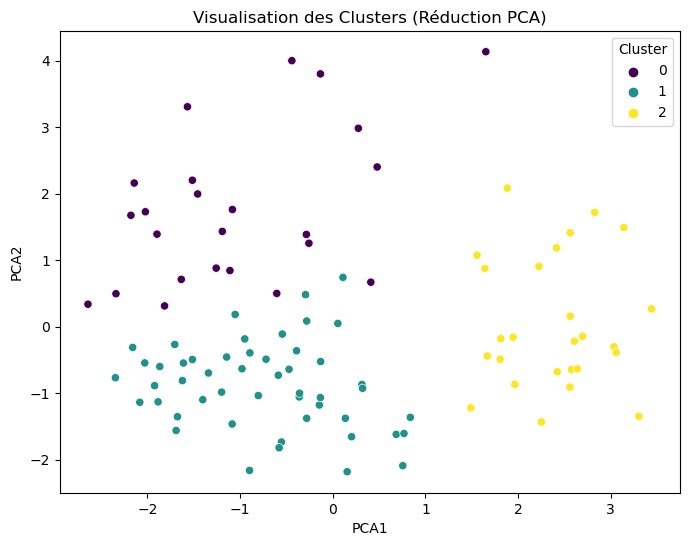

In [21]:
# Visualise the PCA-reduced clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
plt.title("Visualisation des Clusters (Réduction PCA)")
plt.show()

In [22]:
# Analyze the clusters by looking at the mean values of the features
cluster_analysis = df.groupby('Cluster').mean(numeric_only=True)
print(cluster_analysis)

         Fan Challenges Completed  Predictive Accuracy (%)  \
Cluster                                                      
0                        2.541667                83.541667   
1                        7.480000                70.880000   
2                        5.538462                75.000000   

         Virtual Merchandise Purchases  Sponsorship Interactions (Ad Clicks)  \
Cluster                                                                        
0                             2.583333                              8.666667   
1                             2.640000                              7.700000   
2                             2.807692                             10.576923   

         Time on Live 360 (mins)  Real-Time Chat Activity (Messages Sent)  \
Cluster                                                                     
0                     153.000000                                26.791667   
1                     143.440000                         